## 0. Load datasets

In [40]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from sklearn import ensemble, linear_model

In [2]:
# Grouped Standard Scaler
class GroupedStandardScaler(BaseEstimator, TransformerMixin):
    """
    Standardize features by removing the mean and scaling to unit variance,
    computed separately for each group defined by a categorical variable.
    
    Parameters
    ----------
    group_col : str
        Name of the categorical column to group by for standardization
    
    with_mean : bool, default=True
        If True, center the data before scaling
    
    with_std : bool, default=True
        If True, scale the data to unit variance
    
    Attributes
    ----------
    group_means_ : dict
        Dictionary mapping group values to mean arrays
    
    group_stds_ : dict
        Dictionary mapping group values to standard deviation arrays
    
    feature_names_ : list
        List of feature column names (excluding group_col)
    
    groups_ : array
        Unique group values seen during fit
    """
    
    def __init__(self, group_col, with_mean=True, with_std=True):
        self.group_col = group_col
        self.with_mean = with_mean
        self.with_std = with_std
    
    def fit(self, X, y=None):
        """
        Compute the mean and std to be used for later scaling, per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data used to compute the per-group means and standard deviations
            used for later scaling along the features axis.
        
        y : None
            Ignored
        
        Returns
        -------
        self : object
            Fitted scaler
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Store feature names (excluding group column)
        self.feature_names_ = [col for col in X.columns if col != self.group_col]
        
        # Use groupby for vectorized computation
        grouped = X.groupby(self.group_col)[self.feature_names_]
        
        if self.with_mean:
            self.group_means_ = grouped.mean()
        else:
            self.group_means_ = pd.DataFrame(
                0, 
                index=grouped.groups.keys(), 
                columns=self.feature_names_
            )
        
        if self.with_std:
            self.group_stds_ = grouped.std()
            # Replace zero std with 1 to avoid division by zero
            self.group_stds_ = self.group_stds_.replace(0, 1.0)
        else:
            self.group_stds_ = pd.DataFrame(
                1.0, 
                index=grouped.groups.keys(), 
                columns=self.feature_names_
            )
        
        return self
    
    def transform(self, X):
        """
        Perform standardization by centering and scaling per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data to transform
        
        Returns
        -------
        X_transformed : pandas DataFrame of shape (n_samples, n_features)
            Transformed DataFrame
        """
        check_is_fitted(self, ['group_means_', 'group_stds_', 'feature_names_'])
        
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Create a copy to avoid modifying original
        X_transformed = X.copy()
        
        # Align means and stds with X using merge (much faster than map)
        means_aligned = X[[self.group_col]].join(
            self.group_means_, on=self.group_col, how='left'
        )
        stds_aligned = X[[self.group_col]].join(
            self.group_stds_, on=self.group_col, how='left'
        )
        
        # Vectorized standardization
        X_transformed[self.feature_names_] = (
            X[self.feature_names_].values - means_aligned[self.feature_names_].values
        ) / stds_aligned[self.feature_names_].values
        
        # Check for unseen groups (NaN values after join)
        if means_aligned[self.feature_names_].isna().any().any():
            unseen_groups = X.loc[means_aligned[self.feature_names_].isna().any(axis=1), self.group_col].unique()
            import warnings
            warnings.warn(f"Found unseen groups during transform: {unseen_groups}. These samples will not be standardized.")
            # Keep original values for unseen groups (where NaN resulted)
            nan_mask = means_aligned[self.feature_names_].isna().any(axis=1)
            X_transformed.loc[nan_mask, self.feature_names_] = X.loc[nan_mask, self.feature_names_]
        
        return X_transformed.drop(columns=self.group_col)
    
    def fit_transform(self, X, y=None):
        """
        Fit to data, then transform it.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            Input data
        
        y : None
            Ignored
        
        Returns
        -------
        X_transformed : pandas DataFrame of shape (n_samples, n_features)
            Transformed DataFrame
        """
        return self.fit(X, y).transform(X)
    
    def inverse_transform(self, X):
        """
        Scale back the data to the original representation per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data to inverse transform
        
        Returns
        -------
        X_original : pandas DataFrame of shape (n_samples, n_features)
            DataFrame in original scale
        """
        check_is_fitted(self, ['group_means_', 'group_stds_', 'feature_names_'])
        
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Create a copy
        X_original = X.copy()
        
        # Align means and stds with X using merge
        means_aligned = X[[self.group_col]].join(
            self.group_means_, on=self.group_col, how='left'
        )
        stds_aligned = X[[self.group_col]].join(
            self.group_stds_, on=self.group_col, how='left'
        )
        
        # Vectorized inverse transformation
        X_original[self.feature_names_] = (
            X[self.feature_names_].values * stds_aligned[self.feature_names_].values
        ) + means_aligned[self.feature_names_].values
        
        return X_original
        


In [41]:
# Helper functions
def get_balanced_df_by_category(df,category,subsample=None,replacement=True):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]

    num_to_sample = min(subsample if subsample is not None else num_per_category.min(), num_per_category.min())
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member.sample(num_to_sample,replace=replacement))
        else:
            output.append(member.sample(num_to_sample,replace=replacement))
    output = pd.concat(output,ignore_index=True)
    
    return output

def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    groupby_name = 'Region',
                    Niter:int=100,
                    model_params = {},
                    measurement_level_name:str='Measurement'):
    training_set = []
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      classifier(random_state=i,**model_params) )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        # X['Region'] = df_['Region']
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,random_state=i+1)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))

        training_set.append((X_train,y_train,X_test,y_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models,training_set]
    

In [42]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
figure_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Random_forest_birth'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
births = pd.read_pickle(path.join(dataset_dir,f'births.pkl'))

# censor the 'answers'
features2drop = [(f,a) for f,a in births.columns if 'Time' in f]
features2drop += [(f,a) for f,a in births.columns if 'Manual' in f]
features2drop += [(f,a) for f,a in births.columns if 'duration' in f]
features2drop += [(f,a) for f,a in births.columns if 'Total' in f]
features2drop += [(f,a) for f,a in births.columns if 'cell coords' in f]
features2drop += [(f,a) for f,a in births.columns if 'standard' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in births.columns if 'smoothed' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in births.columns if 'exponential' in f and not 'G1 only' in f]
features2drop += [(f,a) for f,a in births.columns if 'FUCCI' in f]
features2drop += [(f,a) for f,a in births.columns if 'H2B' in f]
features2drop += [(f,a) for f,a in births.columns if '2um' in f]
features2drop += [(f,a) for f,a in births.columns if '10um' in f]
features2drop += [(f,a) for f,a in births.columns if '15um' in f]
features2drop += [(f,a) for f,a in births.columns if 'Total' in f]

features2drop += ['Z','Z-cyto']
births = births[births['Fate known','Meta']]
births = births.drop(features2drop,axis=1)


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_82519/3507462833.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  births = births.drop(features2drop,axis=1)


## 1. Predict from daughter birth frame

In [43]:
births['Region'] = [f[0] for f in births.index.get_level_values(1).str.split('_',expand=True)]
len(births)

757

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_82519/766081683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Region'] = births['Region']
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_82519/4132026614.py:132: UserWarning: Found unseen groups during transform: ['R1' 'R2']. These samples will not be standardized.
  warnings.warn(f"Found unseen groups during transform: {unseen_groups}. These samples will not be standardized.")
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1149: Runt

Text(0, 0.5, 'Scaled across regions')

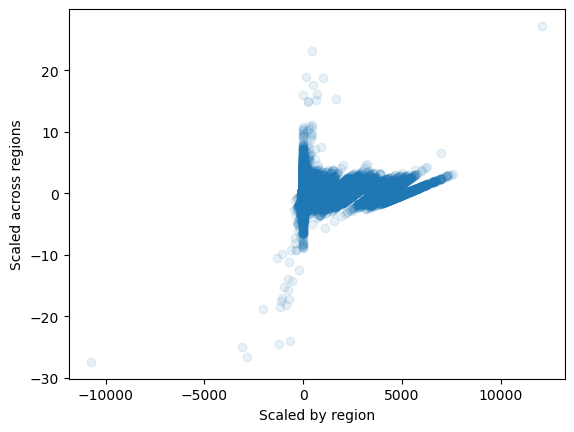

In [14]:
# Check scaling functions

scaler = GroupedStandardScaler('Region')
X = births.xs('Measurement',level=1,axis=1)
X['Region'] = births['Region']
scaled_by_region = scaler.fit_transform(X)

standard_scaler = preprocessing.StandardScaler()
scaled_standard = standard_scaler.fit_transform(X.drop(columns='Region'))

plt.scatter(scaled_by_region.values.flatten(),scaled_standard.flatten() , alpha=0.1)
plt.xlabel('Scaled by region'); plt.ylabel('Scaled across regions')

In [ ]:
# Run classifier
# axis0: observation axis1: prediction

feature2predict = 'Will differentiate'
predictions,models,training_set = predict_feature(births, ensemble.RandomForestClassifier,
                                     feature2predict,Niter=100)
np.savez(path.join(figure_dir,'predictions_models'),{'predictions':predictions,'models':models,'training_set':training_set})

  0%|                                                                                                 | 0/100 [00:00<?, ?it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
  1%|▉                                                                                        | 1/100 [00:00<00:57,  1.72it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum

0.8867299353937953


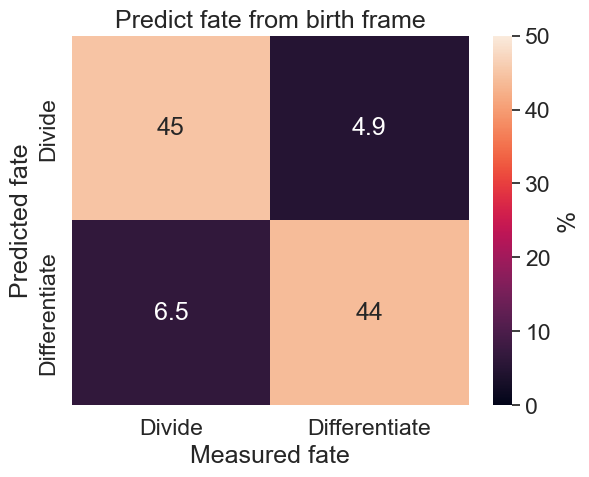

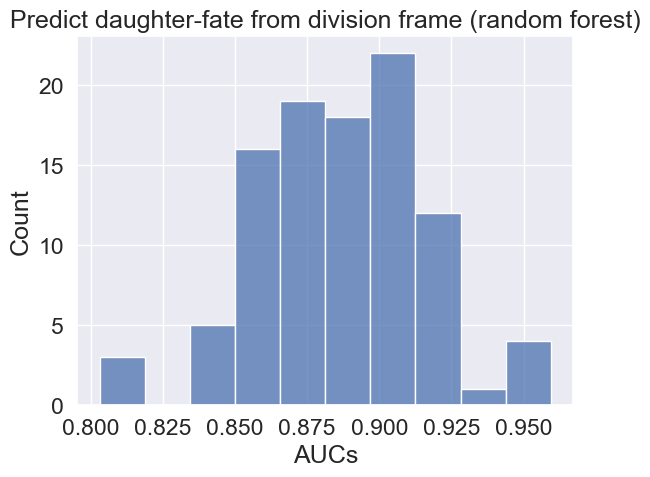

In [47]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

sb.set(font_scale=1.5)  # crazy big
plt.title('Predict fate from birth frame')
sb.heatmap(avg_confusion.mean(axis=0)*100,annot=True,vmin=0,vmax=50,
           cbar_kws={'label':'%'})
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')
plt.savefig(path.join(figure_dir,'confusion_matrix.svg'))

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')
print(f'{AUCs.mean()}')
plt.savefig(path.join(figure_dir,'AUC.svg'))

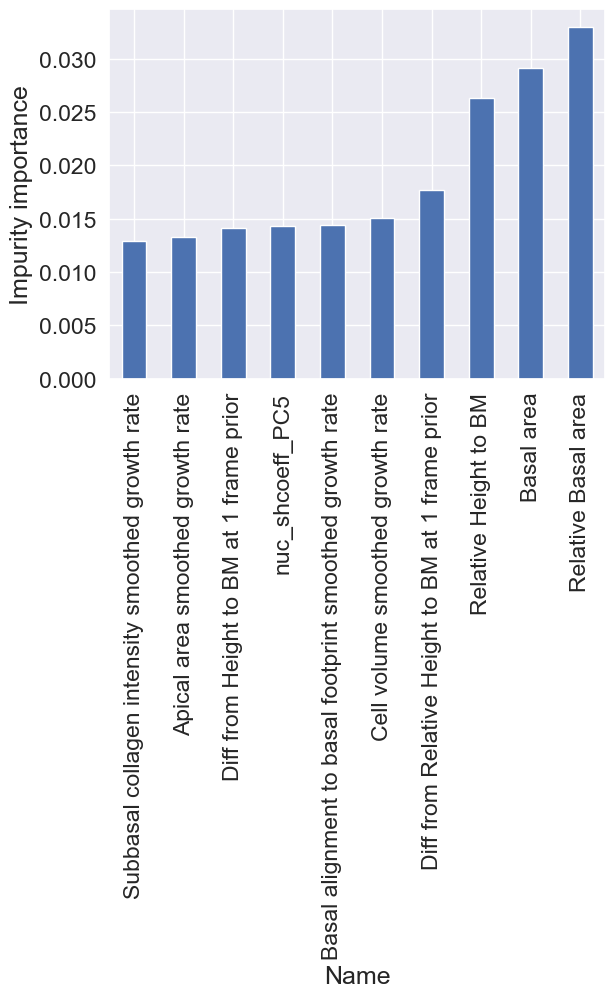

In [48]:
feat_names = births.xs('Measurement',level=1,axis=1).columns
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,:] = m[1].feature_importances_

importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(10).plot.bar()

plt.ylabel('Impurity importance')
plt.savefig(path.join(figure_dir,'impurity_importance.svg'))

importances.mean().sort_values().to_csv(path.join(figure_dir,'importances.csv'))

### Feature selection

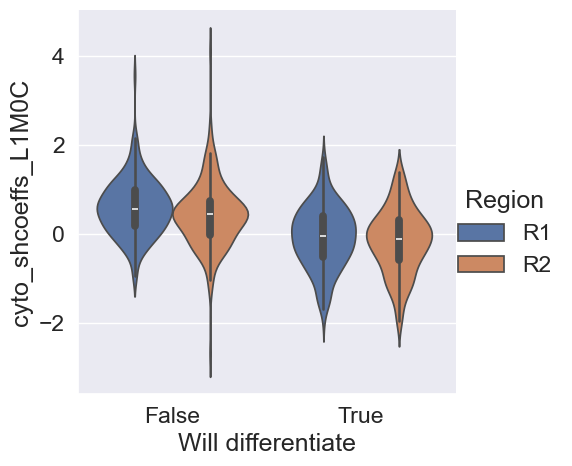

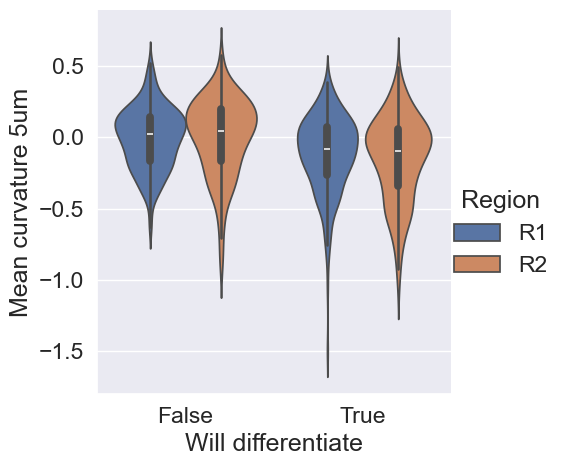

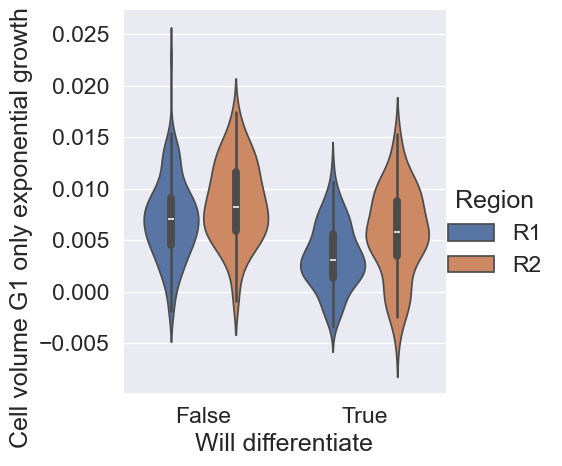

In [27]:
sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='cyto_shcoeffs_L1M0C',kind='violin',hue='Region')
# sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='Basal area',kind='violin',hue='Region')
# sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='Relative Basal area',kind='violin',hue='Region')
sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='Mean curvature 5um',kind='violin',hue='Region')
# sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='Relative Height to BM',kind='violin',hue='Region')
sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='Cell volume G1 only exponential growth rate',kind='violin',hue='Region')
# sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='Relative Manual cell volume',kind='violin')
# sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='Collagen intensity smoothed growth rate',kind='swarm')
# sb.catplot(births.droplevel(axis=1,level=1),x=feature2predict,y='Basal alignment smoothed growth rate',kind='swarm')

### Model-based feature selection

### RFE

In [227]:
X = births.xs('Measurement',level=1,axis=1)
y = births[feature2predict,'Meta']

model = ensemble.RandomForestClassifier().fit(X,y)

results = feature_selection.RFECV(model).fit(X,y)

<ErrorbarContainer object of 3 artists>

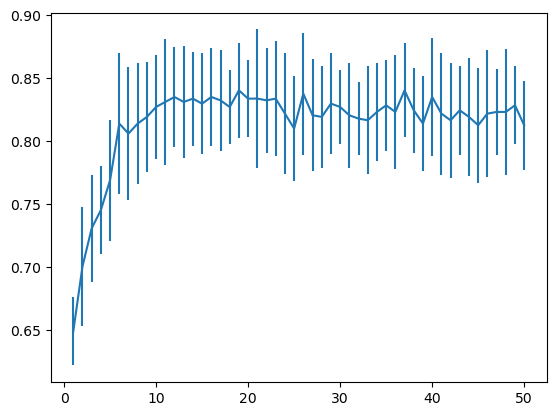

In [228]:
plt.errorbar(x=results.cv_results_['n_features'][:50],
        y=results.cv_results_['mean_test_score'][:50],
        yerr=results.cv_results_['std_test_score'][:50])


In [232]:
print(f'# optimal features: {results.n_features_}')

selected = X.columns[ results.ranking_ == 1]
print(selected)


# optimal features: 19
Index(['Basal area', 'cyto_shcoeffs_L1M0C', 'nuc_shcoeffs_L1M0C',
       'nuc_shcoeffs_surface_area', 'Nuclear volume smoothed growth rate',
       'Nuclear volume G1 only exponential growth rate',
       'Cell volume smoothed growth rate',
       'Cell volume G1 only exponential growth rate',
       'Mean FUCCI intensity smoothed growth rate',
       'Basal area smoothed growth rate', 'Apical area smoothed growth rate',
       'Basal alignment smoothed growth rate', 'Relative Mean H2B intensity',
       'Relative Basal area', 'Relative Height to BM',
       'Relative nuc_shcoeffs_L0M0C',
       'Relative Cell volume G1 only exponential growth rate',
       'Relative Height to BM at 1 frame prior',
       'Relative Cell volume at 1 frame prior'],
      dtype='object', name='Name')


## Misc: visualizations

<Figure size 640x480 with 0 Axes>

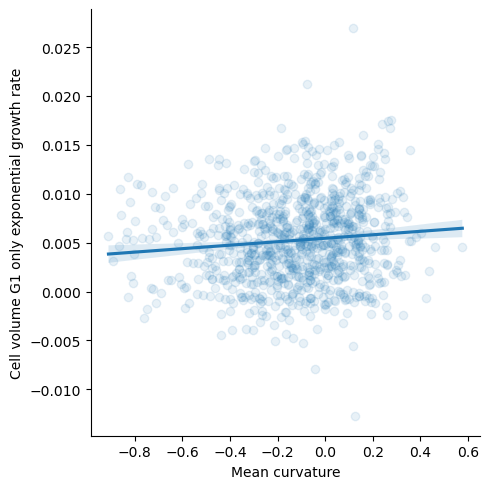

<Figure size 640x480 with 0 Axes>

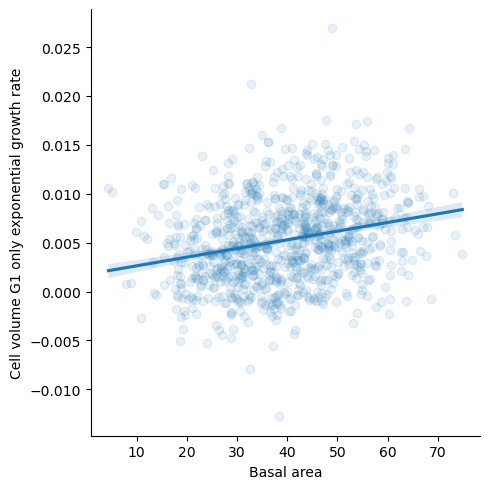

In [539]:
plt.figure()
x = 'Mean curvature'
y = 'Cell volume G1 only exponential growth rate'
sb.lmplot(all_df.droplevel(axis=1,level=1)[[x,y]].groupby('TrackID').mean(),x=x,y=y,
          scatter_kws={'alpha':0.1})

plt.figure()
x = 'Basal area'
y = 'Cell volume G1 only exponential growth rate'
sb.lmplot(all_df.droplevel(axis=1,level=1)[[x,y]].groupby('TrackID').mean(),x=x,y=y,
          scatter_kws={'alpha':0.1}, fit_reg=True)

In [227]:
features2drop = [f for f in all_df.droplevel(axis=1,level=1).columns if 'smoothed' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'shcoeffs' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'prior' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'standard' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'BM' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'intensity' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'Time' in f]
A = all_df.droplevel(axis=1,level=1).drop(
    columns=['X','X-pixels','Y','Y-pixels','X-cyto','Y-cyto','Z','Z-cyto',
             'Daughter a','Daughter b','Mother','Sister']+features2drop).select_dtypes(numerics).corr(numeric_only=True)

B = A.abs().unstack().sort_values(ascending=False)

unique_pairs = []
# Iterate over the top pairs and add only unique pairs to the list
for pair in B.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)

# Create a dataframe with the top pairs and their correlation coefficients
corr_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs):
    corr_df.loc[i] = [pair[0], pair[1], B.loc[pair[0], pair[1]]]

display(corr_df.dropna().head(50))


,feature_1,feature_2,corr_coef
0,Nuclear bbox bottom,Nuclear bbox top,0.979166
1,Nuclear volume exponential growth rate,Nuclear volume (filter_name) exponential growt...,0.919772
2,Cell volume exponential growth rate,Cell volume (filter_name) exponential growth rate,0.904737
3,Planar component 2,Planar component 1,0.823052
4,Axial component,Middle area,0.747579
5,Right,Left,0.747405
6,Mean curvature - cell coords,Nuclear bbox bottom,0.742856
7,Nuclear volume,Cell volume,0.731716
8,Nuclear bbox top,Mean curvature - cell coords,0.714124
9,Cell height,Planar component 1,0.693165
